<a href="https://colab.research.google.com/github/YamanItech/AI/blob/main/insectv2Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/pest-20250508T182454Z-001.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/pest')


KeyboardInterrupt: 

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
import os
import time

In [76]:

train_dir ="/content/drive/MyDrive/pest/pest/train"
test_dir = "/content/drive/MyDrive/pest/pest/test"



#Data Analysis and Preprocessing

**Dataset Classes**

In [77]:
#No of Classes
train_classes = sorted(os.listdir(train_dir))
test_classes = sorted(os.listdir(test_dir))

if not train_classes:
    print("No class directories found in the train folder")
else:
    print(f"Found {len(train_classes)} classes: {train_classes}")

Found 9 classes: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


**Test corrupted image**


In [97]:
from PIL import Image, UnidentifiedImageError
import os

def clean_corrupted_images(directory):
    print(f"\nChecking: {directory}")
    deleted_count = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except (IOError, UnidentifiedImageError) as e:
                    print(f"Deleting corrupted image: {img_path} - Reason: {e}")
                    os.remove(img_path)
                    deleted_count += 1

    if deleted_count == 0:
        print("No corrupted images found.")
    else:
        print(f"Done. Deleted {deleted_count} corrupted image(s).")

# Set your directories
train_dir = "/content/drive/MyDrive/pest/pest/train"
test_dir = "/content/drive/MyDrive/pest/pest/test"

# Run cleaning
clean_corrupted_images(train_dir)
clean_corrupted_images(test_dir)



Checking: /content/drive/MyDrive/pest/pest/train
No corrupted images found.

Checking: /content/drive/MyDrive/pest/pest/test
Deleting corrupted image: /content/drive/MyDrive/pest/pest/test/mites/jpg_53.jpg - Reason: cannot identify image file '/content/drive/MyDrive/pest/pest/test/mites/jpg_53.jpg'
Deleting corrupted image: /content/drive/MyDrive/pest/pest/test/aphids/jpg_33.jpg - Reason: cannot identify image file '/content/drive/MyDrive/pest/pest/test/aphids/jpg_33.jpg'
Done. Deleted 2 corrupted image(s).


**Total images**

In [98]:
import os

def count_images_per_class(base_dir, class_names):
    image_counts = {}
    total = 0
    for cls in class_names:
        class_path = os.path.join(base_dir, cls)
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])
        image_counts[cls] = num_images
        total += num_images
    return image_counts, total

# Get class names
train_classes = sorted(os.listdir(train_dir))
test_classes = sorted(os.listdir(test_dir))

# Count images
train_counts, total_train = count_images_per_class(train_dir, train_classes)
test_counts, total_test = count_images_per_class(test_dir, test_classes)

# Collect all unique classes (for safety, in case train/test differ)
all_classes = sorted(set(train_counts.keys()) | set(test_counts.keys()))

# Header
print("Images per Class")
print("=" * 59)
print(f"{'Class Name':<30}{'Train Images':>15}{'Test Images':>15}")
print("=" * 59)

# Rows
for cls in all_classes:
    train_num = train_counts.get(cls, 0)
    test_num = test_counts.get(cls, 0)
    print(f"{cls:<30}{train_num:>15}{test_num:>15}")

# Totals
print("=" * 59)
print(f"{'Total training images:':<30}{total_train}")
print(f"{'Total testing images:':<30}{total_test}")
print(f"{'Total images:':<30}{total_train + total_test}")


Images per Class
Class Name                       Train Images    Test Images
aphids                                    266             43
armyworm                                  223             43
beetle                                    291             50
bollworm                                  245             36
grasshopper                               277             46
mites                                     254             41
mosquito                                  295             50
sawfly                                    200             37
stem_borer                                181             36
Total training images:        2232
Total testing images:         382
Total images:                 2614


**Defining image size and batch size**

In [99]:
# Define image size and batch size
IMG_HEIGHT, IMG_WIDTH = 150, 150
IMG_CHANNELS = 3  # RGB; change to 1 for grayscale
BATCH_SIZE = 32

**Data augmentation**

In [100]:
# Enhanced data augmentation to reduce overfitting
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Increased from 15
    width_shift_range=0.2,  # Increased from 0.1
    height_shift_range=0.2,  # Increased from 0.1
    horizontal_flip=True,
    zoom_range=0.2,  # Added
    shear_range=0.2,  # Added
    validation_split=0.2
)

**Training generator**

In [101]:
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

Found 1788 images belonging to 9 classes.


**Validation generator**

In [102]:
val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 444 images belonging to 9 classes.


**Test generator**

In [103]:
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 382 images belonging to 9 classes.


In [104]:
# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {class_names}")

Number of classes: 9
Class names: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


In [105]:
# Compute class weights for imbalanced classes
labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.9327073552425665), 1: np.float64(1.1098696461824953), 2: np.float64(0.8526466380543634), 3: np.float64(1.0136054421768708), 4: np.float64(0.8948948948948949), 5: np.float64(0.9738562091503268), 6: np.float64(0.8418079096045198), 7: np.float64(1.2416666666666667), 8: np.float64(1.3701149425287356)}


In [106]:
# Show class distribution
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for cls, count in zip(unique, counts):
    print(f"Class {class_names[int(cls)]}: {count} samples")

Class distribution:
Class aphids: 213 samples
Class armyworm: 179 samples
Class beetle: 233 samples
Class bollworm: 196 samples
Class grasshopper: 222 samples
Class mites: 204 samples
Class mosquito: 236 samples
Class sawfly: 160 samples
Class stem_borer: 145 samples


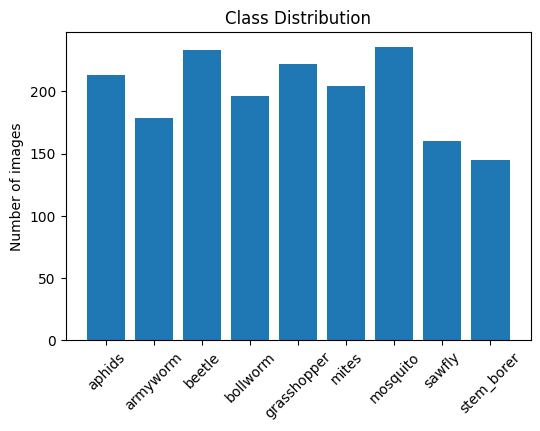

In [107]:
# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_names, counts)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.ylabel("Number of images")
plt.show()

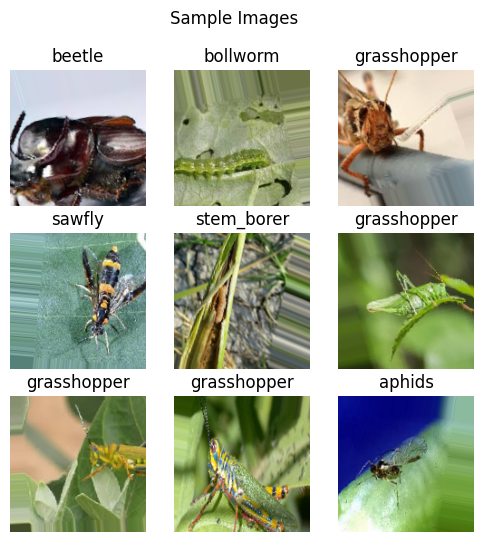

In [108]:
# Display sample images
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(class_names[int(y_batch[i])])
    plt.axis('off')
plt.suptitle("Sample Images")
plt.show()

# Baseline Model

In [109]:
# Define callbacks for underfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),  # Stop if val loss doesn't improve
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)  # Reduce LR on plateau
]

In [110]:
# Build baseline CNN with Dropout and L2 to reduce overfitting
model_baseline = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

In [111]:
# Compile model
model_baseline.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [112]:
# Train model
history_baseline = model_baseline.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,  # Increased to address underfitting
    class_weight=class_weights_dict,  # Handle class imbalance
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 473ms/step - accuracy: 0.1209 - loss: 2.5145 - val_accuracy: 0.2410 - val_loss: 2.2088 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 395ms/step - accuracy: 0.2445 - loss: 2.1822 - val_accuracy: 0.3198 - val_loss: 1.9624 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 409ms/step - accuracy: 0.3138 - loss: 1.9861 - val_accuracy: 0.3063 - val_loss: 2.0057 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 407ms/step - accuracy: 0.3322 - loss: 1.9307 - val_accuracy: 0.3378 - val_loss: 1.9706 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step - accuracy: 0.3306 - loss: 1.9164 - val_accuracy: 0.3829 - val_loss: 1.9392 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 403ms/step - accuracy: 0.3796 - loss: 1.8004 - val_accuracy: 0.3153 - val_loss: 1.9384 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 399ms/step - accuracy: 0.3879 - l

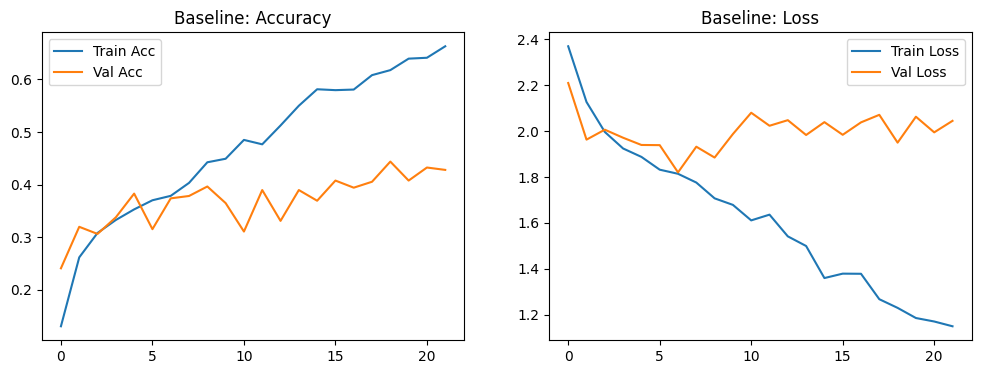

In [113]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Train Acc')
plt.plot(history_baseline.history['val_accuracy'], label='Val Acc')
plt.title("Baseline: Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Val Loss')
plt.title("Baseline: Loss")
plt.legend()
plt.show()

In [114]:
# Evaluate on test set
test_loss, test_acc = model_baseline.evaluate(test_gen, verbose=0)
print(f"Baseline Test Accuracy: {test_acc:.4f}")

Baseline Test Accuracy: 0.4503


In [115]:
# Predictions and classification report
y_pred_baseline = model_baseline.predict(test_gen)
y_pred_classes = np.argmax(y_pred_baseline, axis=1)
y_true = test_gen.classes
print("Classification Report (Baseline):")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 382ms/step
Classification Report (Baseline):
              precision    recall  f1-score   support

      aphids       0.41      0.65      0.50        43
    armyworm       0.47      0.19      0.27        43
      beetle       0.51      0.78      0.61        50
    bollworm       0.36      0.36      0.36        36
 grasshopper       0.40      0.17      0.24        46
       mites       0.33      0.39      0.36        41
    mosquito       0.74      0.74      0.74        50
      sawfly       0.36      0.35      0.36        37
  stem_borer       0.18      0.14      0.16        36

    accuracy                           0.44       382
   macro avg       0.42      0.42      0.40       382
weighted avg       0.43      0.44      0.41       382



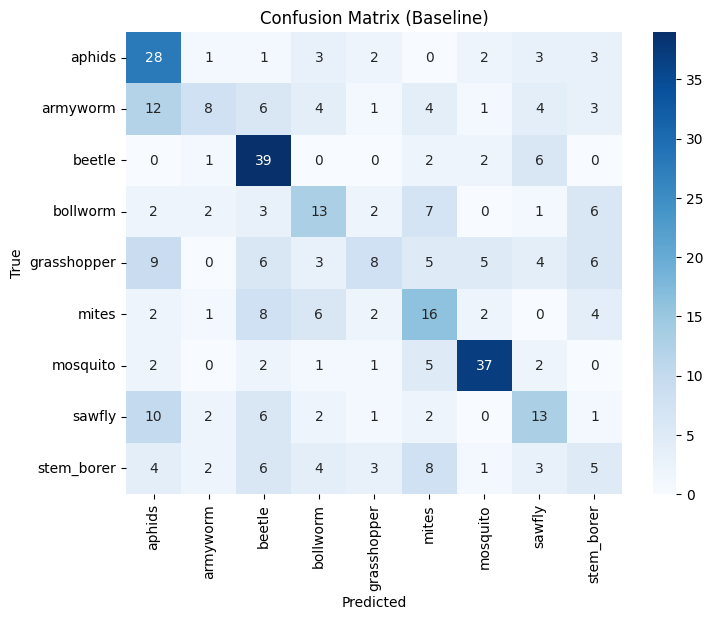

In [116]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix (Baseline)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


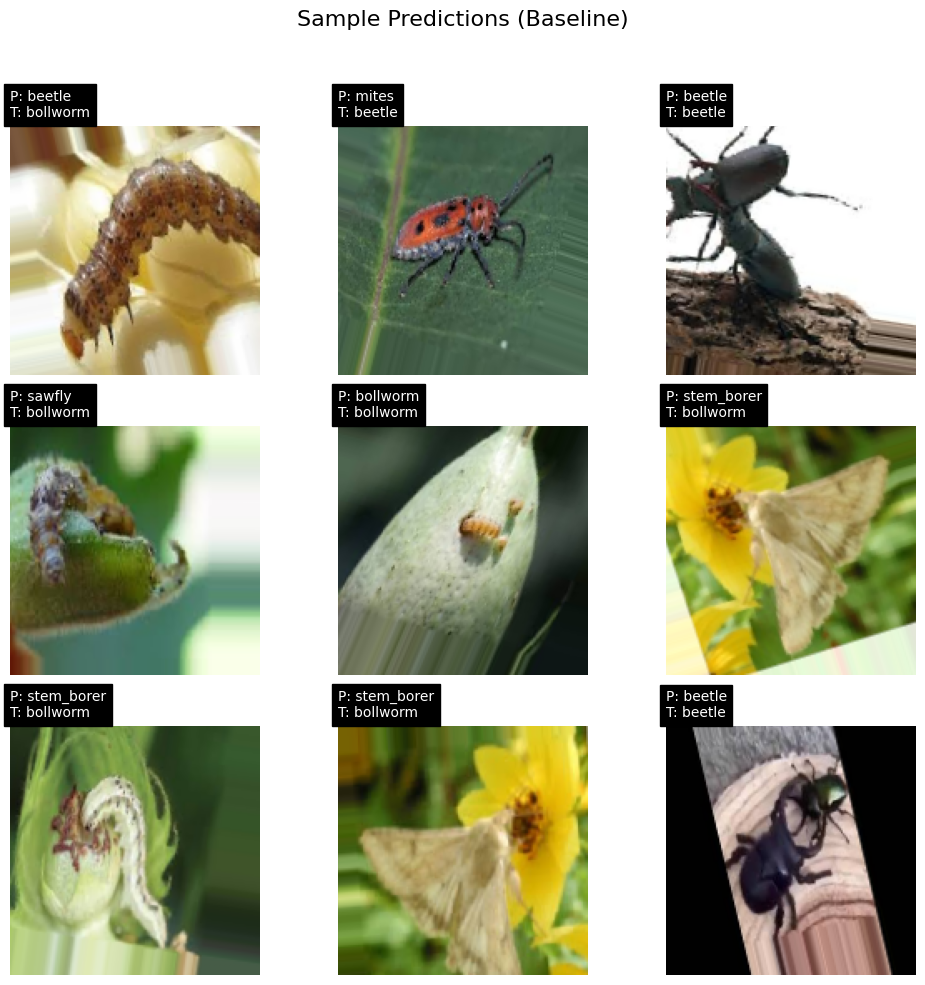

In [151]:
import numpy as np

# Sample predictions
x_test_batch, y_test_batch = next(test_gen)
y_pred_batch = np.argmax(model_baseline.predict(x_test_batch), axis=1)

# Randomly shuffle indices within the batch to display different images each time
random_indices = np.random.permutation(x_test_batch.shape[0])[:9]  # Select 9 random indices from 0 to 31

plt.figure(figsize=(10, 10))  # Larger figure for clarity
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_batch[idx])

    pred_label = class_names[y_pred_batch[idx]]
    true_label = class_names[int(y_test_batch[idx])]

    # Use contrasting text with bounding box for better visibility
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10,
              color='white', backgroundcolor='black', loc='left')
    plt.axis('off')

plt.suptitle("Sample Predictions (Baseline)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

#  Deeper Model with Regularization

In [119]:
# Function to build deeper CNN with tuned regularization
def build_deeper_cnn():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),  # Increased L2
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),  # Reduced from 0.25
        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Classifier
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),  # Simplified
        BatchNormalization(),
        Dropout(0.3),  # Reduced from 0.5
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

In [120]:
# Build and compile deeper model
model_deeper = build_deeper_cnn()
model_deeper.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [122]:
# Train deeper model
start = time.time()
history_deeper = model_deeper.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,  # Increased
    class_weight=class_weights_dict,
    callbacks=callbacks
)
print(f"Deeper model training time: {time.time() - start:.1f} seconds")

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 408ms/step - accuracy: 0.3192 - loss: 2.7029 - val_accuracy: 0.1081 - val_loss: 5.7337 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 402ms/step - accuracy: 0.4130 - loss: 2.4399 - val_accuracy: 0.1059 - val_loss: 4.7892 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 411ms/step - accuracy: 0.4264 - loss: 2.3018 - val_accuracy: 0.1081 - val_loss: 4.0737 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.5325 - loss: 2.1058 - val_accuracy: 0.0811 - val_loss: 4.0131 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 405ms/step - accuracy: 0.5541 - loss: 1.9769 - val_accuracy: 0.1441 - val_loss: 4.1561 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 407ms/step - accuracy: 0.5612 - loss: 1.9975 - val_accuracy: 0.1374 - val_loss: 4.1202 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 396ms/step - accuracy: 0.5742 - l

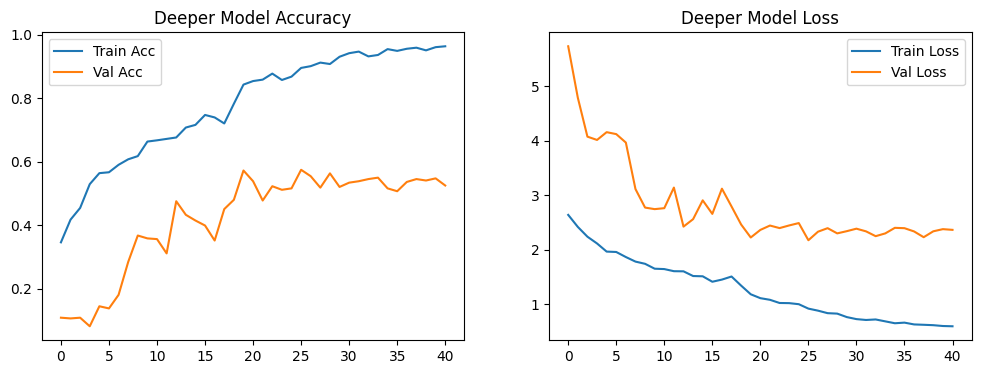

In [124]:
# Plot accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_deeper.history['accuracy'], label='Train Acc')
plt.plot(history_deeper.history['val_accuracy'], label='Val Acc')
plt.title("Deeper Model Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_deeper.history['loss'], label='Train Loss')
plt.plot(history_deeper.history['val_loss'], label='Val Loss')
plt.title("Deeper Model Loss")
plt.legend()
plt.show()

In [125]:
# Evaluate deeper model
test_loss_d, test_acc_d = model_deeper.evaluate(test_gen, verbose=0)
print(f"Deeper Model Test Accuracy: {test_acc_d:.4f}")

Deeper Model Test Accuracy: 0.8560


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 359ms/step
Classification Report (Deeper):
              precision    recall  f1-score   support

      aphids       0.88      0.86      0.87        43
    armyworm       0.82      0.72      0.77        43
      beetle       0.86      0.88      0.87        50
    bollworm       0.76      0.89      0.82        36
 grasshopper       0.80      0.78      0.79        46
       mites       0.84      0.88      0.86        41
    mosquito       0.88      0.90      0.89        50
      sawfly       0.87      0.70      0.78        37
  stem_borer       0.82      0.92      0.87        36

    accuracy                           0.84       382
   macro avg       0.84      0.84      0.83       382
weighted avg       0.84      0.84      0.84       382



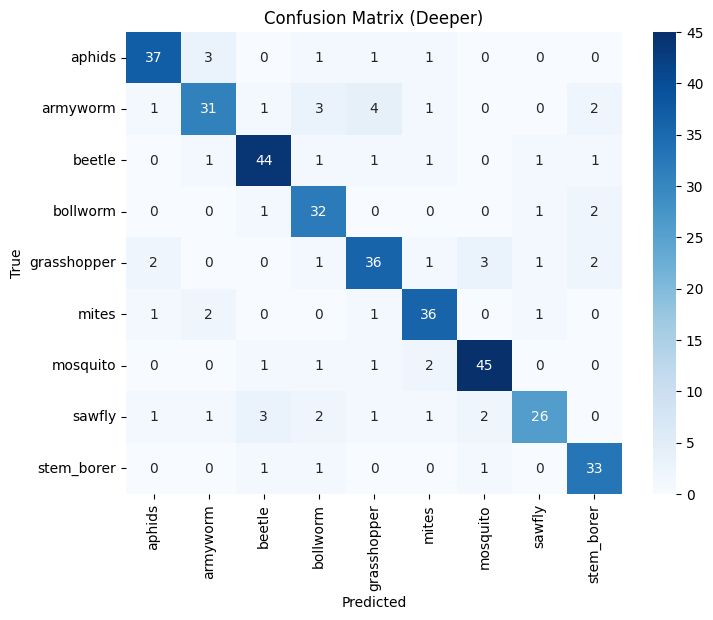

In [126]:
# Predictions
y_pred_deeper = np.argmax(model_deeper.predict(test_gen), axis=1)
print("Classification Report (Deeper):")
print(classification_report(y_true, y_pred_deeper, target_names=class_names))
cm_d = confusion_matrix(y_true, y_pred_deeper)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_d, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix (Deeper)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


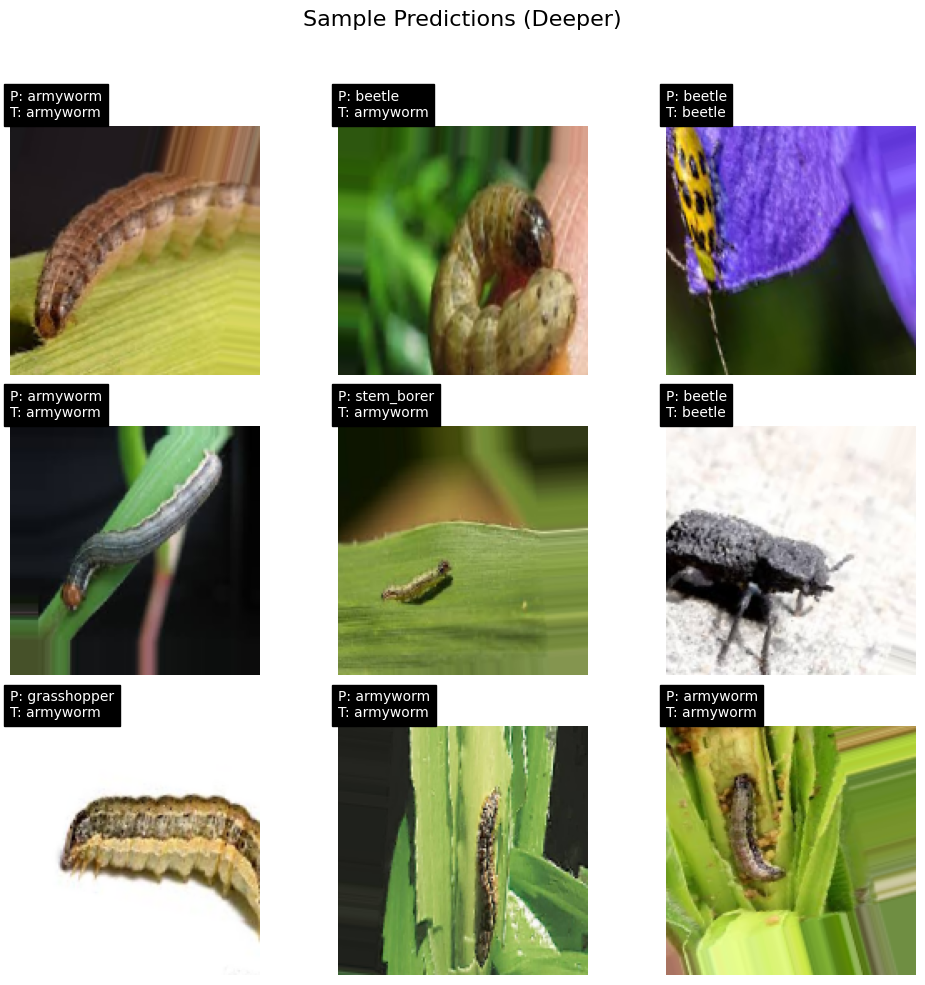

In [149]:
import numpy as np

# Sample predictions (Deeper)
y_pred_batch = np.argmax(model_deeper.predict(x_test_batch), axis=1)

# Randomly shuffle indices within the batch to display different images each time
random_indices = np.random.permutation(x_test_batch.shape[0])[:9]  # Select 9 random indices from 0 to 31

plt.figure(figsize=(10, 10))  # Bigger size for better visibility
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_batch[idx])

    pred_label = class_names[y_pred_batch[idx]]
    true_label = class_names[int(y_test_batch[idx])]

    # Use white text on black background for clarity
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10,
              color='white', backgroundcolor='black', loc='left')
    plt.axis('off')

plt.suptitle("Sample Predictions (Deeper)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Experimentation and Comparison

In [133]:
from tensorflow.keras.optimizers import SGD

# Compare optimizers
adam_acc = test_acc_d

# Deeper model with SGD
model_deeper_sgd = build_deeper_cnn()
model_deeper_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
start = time.time()
history_sgd = model_deeper_sgd.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
sgd_time = time.time() - start
_, sgd_acc = model_deeper_sgd.evaluate(test_gen, verbose=0)
print(f"SGD Test Accuracy: {sgd_acc:.4f} (Time: {sgd_time:.1f}s)")

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 664ms/step - accuracy: 0.1561 - loss: 3.2768 - val_accuracy: 0.1959 - val_loss: 31.2014 - learning_rate: 0.0100
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 413ms/step - accuracy: 0.2406 - loss: 2.9111 - val_accuracy: 0.2523 - val_loss: 3.6905 - learning_rate: 0.0100
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - accuracy: 0.3294 - loss: 2.6515 - val_accuracy: 0.2770 - val_loss: 2.8462 - learning_rate: 0.0100
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 408ms/step - accuracy: 0.3435 - loss: 2.5794 - val_accuracy: 0.3018 - val_loss: 2.6769 - learning_rate: 0.0100
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 433ms/step - accuracy: 0.3591 - loss: 2.4833 - val_accuracy: 0.2883 - val_loss: 2.7454 - learning_rate: 0.0100
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 391ms/step - accuracy: 0.3832 - loss: 2.4435 - val_accuracy: 0.3086 - val_loss: 2.6639 - learning_rate: 0.0100
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.4052 - 

In [134]:
# Report comparison
print(f"Baseline Test Accuracy: {test_acc:.4f}")
print(f"Deeper (Adam) Test Accuracy: {adam_acc:.4f}")
print(f"Deeper (SGD) Test Accuracy: {sgd_acc:.4f}")

Baseline Test Accuracy: 0.4503
Deeper (Adam) Test Accuracy: 0.8560
Deeper (SGD) Test Accuracy: 0.6675


In [135]:
# Summary table
import pandas as pd
results = pd.DataFrame({
    'Model': ['Baseline', 'Deeper (Adam)', 'Deeper (SGD)'],
    'Test Accuracy': [test_acc, adam_acc, sgd_acc]
})
print("\nSummary of Results:")
print(results)


Summary of Results:
           Model  Test Accuracy
0       Baseline       0.450262
1  Deeper (Adam)       0.856021
2   Deeper (SGD)       0.667539
